In [170]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Bulding database

In [171]:
# Import everything needed

import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import MetaData, Column, Integer, String, DateTime, func, ForeignKey
from sqlalchemy.orm import relationship, Session

In [172]:
# Create engine and initiate base class as a root for the rest of the tables
engine = create_engine('sqlite:///igclone.db')
Base = declarative_base()

In [196]:
# Build each table/class

class User(Base):
    __tablename__ = 'users'
    
    id = Column(Integer, primary_key = True)
    username = Column(String(255), unique = True, nullable = False)
    created_at = Column(DateTime(timezone = True), server_default = func.now())
    
    def __repr__(self):
        return "User<%r,%r,%r>"%(self.id,self.username,self.created_at)
    
    
class Photo(Base):
    __tablename__ = 'photos'
    
    id = Column(Integer, primary_key = True)
    image_url = Column(String(255), nullable = True)
    created_at = Column(DateTime(timezone = True), server_default = func.now())
    
    user_id = Column(Integer, ForeignKey('users.id'), nullable = False)
    
    user_photo = relationship('User', backref='photos')
    
    def __repr__(self):
        return "Photo<%r,%r,%r,%r>"%(self.id, self.image_url,self.created_at,self.user_id)
    
class Comment(Base):
    __tablename__ = 'comments'
    
    id = Column(Integer, primary_key = True)
    comment_text = Column(String(255), nullable = True)
    created_at = Column(DateTime(timezone = True), server_default = func.now())
    
    user_id = Column(Integer, ForeignKey('users.id'), nullable = False)
    photo_id = Column(Integer, ForeignKey('photos.id'), nullable = False)
    
    user_comment = relationship('User', backref = 'comments')
    photo_comments = relationship('Photo', backref = 'comments')
    
    def __repr__(self):
        return "Comment <id: %r, created: %r, user: %r, photo: %r, text: %r"%(self.id, self.created_at, self.user_id, self.photo_id, self.comment_text)
    

class Like(Base):
    __tablename__ = 'likes'
    
    created_at = Column(DateTime(timezone = True), server_default = func.now())
    
    user_id = Column(Integer, ForeignKey('users.id'), primary_key = True, nullable = False)
    photo_id = Column(Integer, ForeignKey('photos.id'), primary_key = True, nullable = False)
    
    user_like = relationship('User', backref = 'likes')
    photo_like = relationship('Photo', backref = 'likes')
    
    def __repr__(self):
        return 'Like <composite pk: %r-%r, created: %r'%(self.user_id,self.photo_id, self.created_at)
    

class Follow(Base):
    __tablename__ = 'follows'
    
    follower_id = Column(Integer, ForeignKey('users.id'), primary_key = True, nullable = False)
    followee_id = Column(Integer, ForeignKey('users.id'), primary_key = True, nullable = False)
    created_at = Column(DateTime(timezone = True), server_default = func.now())
    
    user_follower = relationship("User", foreign_keys=[follower_id], backref = 'followers')
    user_following = relationship('User', foreign_keys=[followee_id], backref = 'following')
    
    def __repr__(self):
        return 'Follow <composite pk: %r-%r, created>'%(self.follower_id, self.followee_id, self.created_at)
    
    
class Tag(Base):
    __tablename__ = 'tags'
    
    id = Column(Integer, primary_key = True)
    tag_name = Column(String(255), unique = True)
    created_at = Column(DateTime(timezone = True), server_default = func.now())
    
    def __repr__(self):
        return"Tag <id: %r, name: %r, created: %r>"%(self.id, self.tag_name, self.created_at)
    

class Photo_tag(Base):
    __tablename__ = 'photoTags'
    
    photo_id = Column(Integer, ForeignKey('photos.id'), primary_key = True, nullable = False)
    tag_id = Column(Integer, ForeignKey('tags.id'), primary_key = True, nullable = False)
    
    photo_photag = relationship('Photo', foreign_keys=[photo_id], backref = 'tags')
    tag_photag = relationship('Tag', foreign_keys=[tag_id], backref = 'photos')
    
    def __repr__(self):
        return "Photo_tag <composite pk: %r-%r"%(self.photo_id, self.tag_id)

D:\anaconda3\lib\site-packages\sqlalchemy\ext\declarative\clsregistry.py:120: SAWarning: This declarative base already contains a class with the same class name and module name as __main__.User, and will be replaced in the string-lookup table.
  item.__name__


InvalidRequestError: Table 'users' is already defined for this MetaData instance.  Specify 'extend_existing=True' to redefine options and columns on an existing Table object.

### Create eveything in database (all python objects which are not holding an db equivalent)

In [174]:
Base.metadata.create_all(engine)

## Data insertion

In [175]:
from sqlalchemy import inspect
from sqlalchemy.sql import text

In [176]:
with open('users.txt', 'r') as file:
    users_creation = text(file.read())

with open('photos.txt', 'r') as file:
    photos_creation = text(file.read())

with open('follows.txt', 'r') as file:
    follows_creation = text(file.read())
    
with open('comments.txt', 'r') as file:
    comments_creation = text(file.read())
    
with open('likes.txt', 'r') as file:
    likes_creation = text(file.read())
    
with open('tags.txt', 'r') as file:
    tags_creation = text(file.read())
    
with open('photags.txt', 'r') as file:
    photags_creation = text(file.read())

In [177]:
data_insertion = [users_creation, photos_creation, follows_creation, comments_creation, likes_creation, tags_creation, photags_creation]

In [178]:
with engine.connect() as con:
    for dedicated in data_insertion:
        con.execute(dedicated)
    
    print('*** Data was loaded ***')

## Data visualization

### Preview database schema

In [179]:
import codecs
import sadisplay 
from graphviz import Source


(dot.exe:18444): Pango-WARNING **: couldn't load font "Bitstream Vera Sans Not-Rotated 8", falling back to "Sans Not-Rotated 8", expect ugly output.


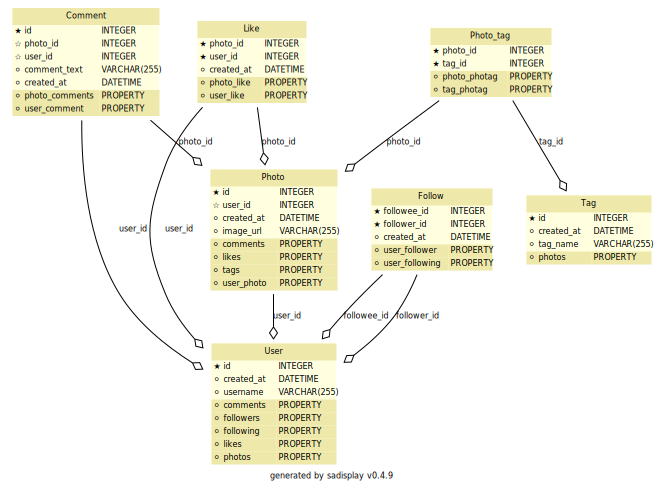

In [180]:
desc = sadisplay.describe(globals().values())

with codecs.open('schema.dot', 'w', encoding='utf-8') as f:
    f.write(sadisplay.dot(desc))
    
Source.from_file('schema.dot', format='png', encoding='utf-8')

### Tables view

In [181]:
users = pd.read_sql('users', con = engine)
photos = pd.read_sql('photos', con = engine)
comments = pd.read_sql('comments', con = engine)
likes = pd.read_sql('likes', con = engine)
follows = pd.read_sql('follows', con = engine)
tags = pd.read_sql('tags', con = engine)

In [182]:
display(users.head())
display(photos.head())
display(comments.head())
display(likes.head())
display(follows.head())
display(tags.head())

,id,username,created_at
0,1,Kenton_Kirlin,2017-02-16 18:22:10.000846
1,2,Andre_Purdy85,2017-04-02 17:11:21.000417
2,3,Harley_Lind18,2017-02-21 11:12:32.000574
3,4,Arely_Bogan63,2016-08-13 01:28:43.000085
4,5,Aniya_Hackett,2016-12-07 01:04:39.000298


,id,image_url,created_at,user_id
0,1,http://elijah.biz,2019-11-11 14:43:37,1
1,2,https://shanon.org,2019-11-11 14:43:37,1
2,3,http://vicky.biz,2019-11-11 14:43:37,1
3,4,http://oleta.net,2019-11-11 14:43:37,1
4,5,https://jennings.biz,2019-11-11 14:43:37,1


,id,comment_text,created_at,user_id,photo_id
0,1,unde at dolorem,2019-11-11 14:43:37,2,1
1,2,quae ea ducimus,2019-11-11 14:43:37,3,1
2,3,alias a voluptatum,2019-11-11 14:43:37,5,1
3,4,facere suscipit sunt,2019-11-11 14:43:37,14,1
4,5,totam eligendi quaerat,2019-11-11 14:43:37,17,1


,created_at,user_id,photo_id
0,2019-11-11 14:43:38,2,1
1,2019-11-11 14:43:38,5,1
2,2019-11-11 14:43:38,9,1
3,2019-11-11 14:43:38,10,1
4,2019-11-11 14:43:38,11,1


,follower_id,followee_id,created_at
0,2,1,2019-11-11 14:43:37
1,2,3,2019-11-11 14:43:37
2,2,4,2019-11-11 14:43:37
3,2,5,2019-11-11 14:43:37
4,2,6,2019-11-11 14:43:37


,id,tag_name,created_at
0,1,sunset,2019-11-11 14:43:38
1,2,photography,2019-11-11 14:43:38
2,3,sunrise,2019-11-11 14:43:38
3,4,landscape,2019-11-11 14:43:38
4,5,food,2019-11-11 14:43:38


## Challenges (SQL like + SQL-Pandas like + ORM like)

### Challenge 1 - Find the 5 oldest users

In [183]:
# SQL like
statement_1 = text("""SELECT * FROM users
                 ORDER BY created_at 
                 LIMIT 5""")
with engine.connect() as con:
    rs = con.execute(statement_1)
    
    for row in rs:
        print('Created_at: ', row[2], ' - Username: ', row[1])

Created_at:  2016-05-06 00:14:21.191  - Username:  Darby_Herzog
Created_at:  2016-05-06 13:04:29.960  - Username:  Emilio_Bernier52
Created_at:  2016-05-08 01:30:40.677  - Username:  Elenor88
Created_at:  2016-05-09 17:30:22.371  - Username:  Nicole71
Created_at:  2016-05-14 07:56:25.835  - Username:  Jordyn.Jacobson2


In [184]:
# PANDAS like
oldest_users_df = pd.read_sql('users', con = engine).sort_values(by = 'created_at')[:5]
oldest_users_df[['username', 'created_at']]

,username,created_at
79,Darby_Herzog,2016-05-06 00:14:21.000191
66,Emilio_Bernier52,2016-05-06 13:04:29.000960
62,Elenor88,2016-05-08 01:30:40.000677
94,Nicole71,2016-05-09 17:30:22.000371
37,Jordyn.Jacobson2,2016-05-14 07:56:25.000835


In [185]:
# ORM like
session = Session(bind=engine)
oldest_users_orm = session.query(User).order_by('created_at')[:5]

for user in oldest_users_orm:
    print('Created at: ', user.created_at, ' - Username:', user.username)

Created at:  2016-05-06 00:14:21.000191  - Username: Darby_Herzog
Created at:  2016-05-06 13:04:29.000960  - Username: Emilio_Bernier52
Created at:  2016-05-08 01:30:40.000677  - Username: Elenor88
Created at:  2016-05-09 17:30:22.000371  - Username: Nicole71
Created at:  2016-05-14 07:56:25.000835  - Username: Jordyn.Jacobson2


### Challenge 2. What day of the week do most users registor on?

In [186]:
week_days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

In [187]:
# SQL like
statement_2 = text("""SELECT 
                        strftime('%w', created_at) AS day, 
                        COUNT(*) AS day_freq 
                    FROM users 
                    GROUP BY day 
                    ORDER BY day_freq DESC""")
with engine.connect() as con:
    rs = con.execute(statement_2)
    
    for row in rs:
        print(row)
    print('\n***** Users register the most on ' + str(week_days[int(row[0])]) + 's')

('0', 16)
('4', 16)
('5', 15)
('1', 14)
('2', 14)
('3', 13)
('6', 12)

***** Users register the most on Saturdays


In [188]:
# Pandas like
df_weekday = pd.read_sql_query("""SELECT 
                            strftime('%w', created_at) AS day, 
                            COUNT(*) AS day_freq 
                        FROM users 
                        GROUP BY day 
                        ORDER BY day_freq DESC""", con =engine)
display(df_weekday)

print('\n***** Users register the most on ' + str(week_days[int(df_weekday.iloc[0,0])]) + 's')

,day,day_freq
0,0,16
1,4,16
2,5,15
3,1,14
4,2,14
5,3,13
6,6,12



***** Users register the most on Sundays


In [189]:
# ORM like
session = Session(bind=engine)
query = session.query(func.strftime('%w',User.created_at), 
                      func.count(User.created_at)).\
            group_by(func.strftime('%w',User.created_at)).\
            order_by(func.count(User.created_at).desc()).all()
print(query)
print('\n***** Users register the most on ' + str(week_days[int(query[0][0])]) + 's')

[('0', 16), ('4', 16), ('5', 15), ('1', 14), ('2', 14), ('3', 13), ('6', 12)]

***** Users register the most on Sundays


### Challenge 3. Find users who have never posted a photo

In [190]:
# SQL like
statement_3 = text("""SELECT 
                        username
                    FROM users
                    LEFT JOIN photos
                        ON users.id = photos.user_id
                    WHERE photos.id IS NULL""")

print('Users who have never posted a photo:\n')
with engine.connect() as con:
    rs = con.execute(statement_3)
    
    for row in rs:
        print('\t'+row[0])

Users who have never posted a photo:

	Aniya_Hackett
	Kasandra_Homenick
	Jaclyn81
	Rocio33
	Maxwell.Halvorson
	Tierra.Trantow
	Pearl7
	Ollie_Ledner37
	Mckenna17
	David.Osinski47
	Morgan.Kassulke
	Linnea59
	Duane60
	Julien_Schmidt
	Mike.Auer39
	Franco_Keebler64
	Nia_Haag
	Hulda.Macejkovic
	Leslie67
	Janelle.Nikolaus81
	Darby_Herzog
	Esther.Zulauf61
	Bartholome.Bernhard
	Jessyca_West
	Esmeralda.Mraz57
	Bethany20


In [191]:
# SQL-Pandas like
df_user_no_photo = pd.read_sql(statement_3, con = engine)

df_user_no_photo

,username
0,Aniya_Hackett
1,Kasandra_Homenick
2,Jaclyn81
3,Rocio33
4,Maxwell.Halvorson
5,Tierra.Trantow
6,Pearl7
7,Ollie_Ledner37
8,Mckenna17
9,David.Osinski47


In [192]:
# ORM like
session = Session(bind=engine)
query = session.query(User.username).\
                outerjoin(Photo).\
                filter(User.photos == None).\
                all()

print('Users who have never posted a photo:\n')
for row in query:
    print('\t'+row[0])

Users who have never posted a photo:

	Aniya_Hackett
	Kasandra_Homenick
	Jaclyn81
	Rocio33
	Maxwell.Halvorson
	Tierra.Trantow
	Pearl7
	Ollie_Ledner37
	Mckenna17
	David.Osinski47
	Morgan.Kassulke
	Linnea59
	Duane60
	Julien_Schmidt
	Mike.Auer39
	Franco_Keebler64
	Nia_Haag
	Hulda.Macejkovic
	Leslie67
	Janelle.Nikolaus81
	Darby_Herzog
	Esther.Zulauf61
	Bartholome.Bernhard
	Jessyca_West
	Esmeralda.Mraz57
	Bethany20


### Challenge 4. Who has the most likes on a single photo?

In [193]:
# SQL like
statement_4 = text("""SELECT
                        username,
                        image_url,
                        photo_id,
                        COUNT(*) AS freq 
                    FROM likes
                    LEFT JOIN photos
                        ON photos.id = likes.photo_id
                    LEFT JOIN users
                        ON users.id = photos.user_id
                    GROUP BY photo_id
                    ORDER BY freq DESC
                    LIMIT 5""")

print('Top 5 most liked photos: \n')
with engine.connect() as con:
    rs = con.execute(statement_4)

    for row in rs:
        print('\tPhoto: ' + row[1] + ' with ' + str(row[3]) + ' likes')
    

Top 5 most liked photos: 

	Photo: https://jarret.name with 48 likes
	Photo: https://celestine.name with 43 likes
	Photo: https://dorcas.biz with 43 likes
	Photo: http://shannon.org with 42 likes
	Photo: http://kenny.com with 41 likes


In [194]:
# SQL-Pandas like
df_most_likes = pd.read_sql(statement_4, con = engine)

display(df_most_likes)

,username,image_url,photo_id,freq
0,Zack_Kemmer93,https://jarret.name,145,48
1,Malinda_Streich,https://celestine.name,127,43
2,Adelle96,https://dorcas.biz,182,43
3,Seth46,http://shannon.org,123,42
4,Presley_McClure,http://kenny.com,30,41


In [195]:
# ORM like
session = Session(bind=engine)
query = session.query(User.username, Photo.image_url, func.count(Photo.image_url)).\
                join(Photo).\
                join(Like).\
                group_by(Like.photo_id).\
                order_by(func.count(Photo.image_url).desc()).\
                all()

print('Top 5 most liked photos: \n')

for row in query[:5]:
    print('\t User: ' + row[0] + ', photo: ' + row[1] + ', likes: ' + str(row[2]))

Top 5 most liked photos: 

	 User: Zack_Kemmer93, photo: https://jarret.name, likes: 48
	 User: Malinda_Streich, photo: https://celestine.name, likes: 43
	 User: Adelle96, photo: https://dorcas.biz, likes: 43
	 User: Seth46, photo: http://shannon.org, likes: 42
	 User: Presley_McClure, photo: http://kenny.com, likes: 41


In [169]:
Base.metadata.drop_all(engine)